# Low level API

## Prerequisites:

- Understanding the gammapy data workflow, in particular what are DL3 events and instrument response functions (IRF).
- Understanding of the data reduction and modeling fitting process as shown in the [analysis with the high level interface tutorial](analysis_1.ipynb)

## Context

This notebook is an introduction to gammapy analysis this time using the lower level classes and functions
the library.
This allows to understand what happens during two main gammapy analysis steps, data reduction and modeling/fitting. 

**Objective: Create a 3D dataset of the Crab using the H.E.S.S. DL3 data release 1 and perform a simple model fitting of the Crab nebula using the lower level gammapy API.**

## Proposed approach:

Here, we have to interact with the data archive (with the `~gammapy.data.DataStore`) to retrieve a list of selected observations (`~gammapy.data.Observations`). Then, we define the geometry of the `~gammapy.datasets.MapDataset` object we want to produce and the maker object that reduce an observation
to a dataset. 

We can then proceed with data reduction with a loop over all selected observations to produce datasets in the relevant geometry and stack them together (i.e. sum them all).

In practice, we have to:
- Create a `~gammapy.data.DataStore` poiting to the relevant data 
- Apply an observation selection to produce a list of observations, a `~gammapy.data.Observations` object.
- Define a geometry of the Map we want to produce, with a sky projection and an energy range.
    - Create a `~gammapy.maps.MapAxis` for the energy
    - Create a `~gammapy.maps.WcsGeom` for the geometry
- Create the necessary makers : 
    - the map dataset maker : `~gammapy.makers.MapDatasetMaker`
    - the background normalization maker, here a `~gammapy.makers.FoVBackgroundMaker`
    - and usually the safe range maker : `~gammapy.makers.SafeRangeMaker`
- Perform the data reduction loop. And for every observation:
    - Apply the makers sequentially to produce the current `~gammapy.datasets.MapDataset`
    - Stack it on the target one.
- Define the `~gammapy.modeling.models.SkyModel` to apply to the dataset.
- Create a `~gammapy.modeling.Fit` object and run it to fit the model parameters
- Apply a `~gammapy.estimators.FluxPointsEstimator` to compute flux points for the spectral part of the fit.

## Setup
First, we setup the analysis by performing required imports.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path
from astropy import units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion

In [3]:
from gammapy.data import DataStore
from gammapy.datasets import MapDataset
from gammapy.maps import WcsGeom, MapAxis
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, FoVBackgroundMaker
from gammapy.modeling.models import (
    SkyModel,
    PowerLawSpectralModel,
    PointSpatialModel,
    FoVBackgroundModel,
)
from gammapy.modeling import Fit
from gammapy.estimators import FluxPointsEstimator

## Defining the datastore and selecting observations

We first use the `~gammapy.data.DataStore` object to access the observations we want to analyse. Here the H.E.S.S. DL3 DR1. 

In [4]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")

In [36]:
from astropy.coordinates import SkyCoord
pos = SkyCoord.from_name("MSH 15-52")
pos.ra, pos.dec

(<Longitude 228.32083333 deg>, <Latitude -59.08166667 deg>)

We can now define an observation filter to select only the relevant observations. 
Here we use a cone search which we define with a python dict.

We then filter the `ObservationTable` with `~gammapy.data.ObservationTable.select_observations()`.

In [37]:
selection = dict(
    type="sky_circle",
    frame="icrs",
    lon=pos.ra,
    lat=pos.dec,
    radius="5 deg",
)
selected_obs_table = data_store.obs_table.select_observations(selection)

We can now retrieve the relevant observations by passing their `obs_id` to the`~gammapy.data.DataStore.get_observations()` method.

In [38]:
observations = data_store.get_observations(selected_obs_table["OBS_ID"])

No HDU found matching: OBS_ID = 20136, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20137, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20151, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20282, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20283, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20301, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20302, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20303, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20322, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20323, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20324, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20325, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20343, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found

## Preparing reduced datasets geometry

Now we define a reference geometry for our analysis, We choose a WCS based geometry with a binsize of 0.02 deg and also define an energy axis: 

In [69]:
energy_axis = MapAxis.from_energy_bounds(1.0, 10.0, 10, unit="TeV")

geom = WcsGeom.create(
    skydir=(pos.ra.value, pos.dec.value),
    binsz=0.02,
    width=(5, 5),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis],
)

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.5, 20, 20, unit="TeV", name="energy_true"
)

Now we can define the target dataset with this geometry.

In [70]:
stacked = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="msh-stacked"
)

## Data reduction

### Create the maker classes to be used

The `~gammapy.datasets.MapDatasetMaker` object is initialized as well as the `~gammapy.makers.SafeMaskMaker` that carries here a maximum offset selection.

In [71]:
offset_max = 2.5 * u.deg
maker = MapDatasetMaker()
maker_safe_mask = SafeMaskMaker(
    methods=["offset-max", "aeff-max"], offset_max=offset_max
)

In [72]:
circle = CircleSkyRegion(
    center=SkyCoord(pos.ra, pos.dec), radius=0.4 * u.deg
)
exclusion_mask = ~geom.region_mask(regions=[circle])
maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)

### Perform the data reduction loop

In [73]:
%%time

for obs in observations:
    # First a cutout of the target map is produced
    cutout = stacked.cutout(
        obs.pointing_radec, width=2 * offset_max, name=f"obs-{obs.obs_id}"
    )
    # A MapDataset is filled in this cutout geometry
    dataset = maker.run(cutout, obs)
    # The data quality cut is applied
    dataset = maker_safe_mask.run(dataset, obs)
    # fit background model
    dataset = maker_fov.run(dataset)
    print(
        f"Background norm obs {obs.obs_id}: {dataset.background_model.spectral_model.norm.value:.2f}"
    )
    # The resulting dataset cutout is stacked onto the final one
    stacked.stack(dataset)

Background norm obs 20136: 1.02
Background norm obs 20137: 1.03
Background norm obs 20151: 0.95
Background norm obs 20282: 0.97
Background norm obs 20283: 0.68
Background norm obs 20301: 0.99
Background norm obs 20302: 1.01
Background norm obs 20303: 1.00
Background norm obs 20322: 1.09
Background norm obs 20323: 1.10
Background norm obs 20324: 1.03
Background norm obs 20325: 1.04
Background norm obs 20343: 0.98
Background norm obs 20344: 1.04
Background norm obs 20345: 1.01
Background norm obs 20346: 1.05
Background norm obs 20365: 0.96
Background norm obs 20366: 1.03
Background norm obs 20367: 0.99
Background norm obs 20368: 0.89
CPU times: user 28.5 s, sys: 340 ms, total: 28.9 s
Wall time: 28.9 s


In [74]:
print(stacked)

MapDataset
----------

  Name                            : msh-stacked 

  Total counts                    : 28394 
  Total background counts         : 27884.41
  Total excess counts             : 509.59

  Predicted counts                : 27884.42
  Predicted background counts     : 27884.41
  Predicted excess counts         : nan

  Exposure min                    : 2.54e+08 m2 s
  Exposure max                    : 1.33e+10 m2 s

  Number of total bins            : 625000 
  Number of fit bins              : 553910 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




### Inspect the reduced dataset

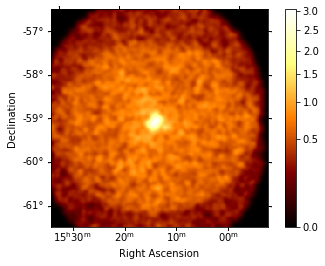

In [75]:
stacked.counts.sum_over_axes().smooth(0.05 * u.deg).plot(
    stretch="sqrt", add_cbar=True
);

## Save dataset to disk

It is common to run the preparation step independent of the likelihood fit, because often the preparation of maps, PSF and energy dispersion is slow if you have a lot of data. We first create a folder:

In [76]:
path = Path("analysis_2")
path.mkdir(exist_ok=True)

And then write the maps and IRFs to disk by calling the dedicated `~gammapy.datasets.MapDataset.write()` method:

In [77]:
filename = path / "msh-stacked-dataset.fits.gz"
stacked.write(filename, overwrite=True)

## Define the model
We first define the model, a `SkyModel`, as the combination of a point source `SpatialModel` with a powerlaw `SpectralModel`:

In [78]:
from gammapy.modeling.models import GaussianSpatialModel

In [79]:

spatial_model = GaussianSpatialModel(
    lon_0=pos.ra, lat_0=pos.dec, sigma=0.3*u.deg, frame="icrs"
)

spectral_model = PowerLawSpectralModel(
    index=2.702,
    amplitude=4.712e-11 * u.Unit("1 / (cm2 s TeV)"),
    reference=1 * u.TeV,
)

sky_model = SkyModel(
    spatial_model=spatial_model, spectral_model=spectral_model, name="crab"
)

bkg_model = FoVBackgroundModel(dataset_name="crab-stacked")

Now we assign this model to our reduced dataset:

In [80]:
stacked.models = [sky_model, bkg_model]

## Fit the model

The `~gammapy.modeling.Fit` class is orchestrating the fit, connecting the `stats` method of the dataset to the minimizer. By default, it uses `iminuit`.

Its constructor takes a list of dataset as argument.

In [81]:
%%time
fit = Fit(optimize_opts={"print_level": 1})
result = fit.run([stacked])

Position <SkyCoord (ICRS): (ra, dec) in deg
    (250.79290208, -59.08166667)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (250.79290208, -59.08166667)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (205.84876458, -59.08166667)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (205.84876458, -59.08166667)> is outside valid IRF map range, using nearest IRF defined within


CPU times: user 9.9 s, sys: 107 ms, total: 10 s
Wall time: 10 s


The `FitResult` contains information about the optimization and parameter error calculation.

In [82]:
print(result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 242
	total stat : 210660.30

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 242
	total stat : 210660.30




The fitted parameters are visible from the `~astropy.modeling.models.Models` object.

In [83]:
stacked.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,link
str4,str8,str9,float64,str14,float64,float64,float64,bool,str1
crab,spectral,index,2.3175e+00,,1.076e-01,nan,nan,False,
crab,spectral,amplitude,7.1479e-12,cm-2 s-1 TeV-1,7.199e-13,nan,nan,False,
crab,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
crab,spatial,lon_0,2.2854e+02,deg,1.617e-02,nan,nan,False,
crab,spatial,lat_0,-5.9173e+01,deg,8.440e-03,-9.000e+01,9.000e+01,False,
crab,spatial,sigma,8.7456e-02,deg,6.440e-03,0.000e+00,nan,False,
crab,spatial,e,0.0000e+00,,0.000e+00,0.000e+00,1.000e+00,True,
crab,spatial,phi,0.0000e+00,deg,0.000e+00,nan,nan,True,


### Inspecting residuals

For any fit it is useful to inspect the residual images. We have a few options on the dataset object to handle this. First we can use `.plot_residuals_spatial()` to plot a residual image, summed over all energies:

ValueError: Passing parameters norm and vmin/vmax simultaneously is not supported. Please pass vmin/vmax directly to the norm when creating it.

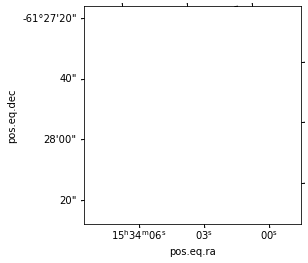

In [84]:
stacked.plot_residuals_spatial();

In addition, we can also specify a region in the map to show the spectral residuals:

In [ ]:
region = CircleSkyRegion(
    center=pos, radius=0.5 * u.deg
)

In [ ]:
stacked.plot_residuals(
    kwargs_spatial=dict(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5),
    kwargs_spectral=dict(region=region),
);

We can also directly access the `.residuals()` to get a map, that we can plot interactively:

In [ ]:
residuals = stacked.residuals(method="diff")
residuals.smooth("0.08 deg").plot_interactive(
    cmap="coolwarm", vmin=-0.2, vmax=0.2, stretch="linear", add_cbar=True
);

## Plot the fitted spectrum

### Making a butterfly plot 

The `SpectralModel` component can be used to produce a, so-called, butterfly plot showing the envelope of the model taking into account parameter uncertainties:

In [ ]:
spec = sky_model.spectral_model

Now we can actually do the plot using the `plot_error` method:

In [ ]:
energy_bounds = [1, 10] * u.TeV
spec.plot(energy_bounds=energy_bounds, energy_power=2)
ax = spec.plot_error(energy_bounds=energy_bounds, energy_power=2)

### Computing flux points

We can now compute some flux points using the `~gammapy.estimators.FluxPointsEstimator`. 

Besides the list of datasets to use, we must provide it the energy intervals on which to compute flux points as well as the model component name. 

In [ ]:
energy_edges = [1, 2, 4, 10] * u.TeV
fpe = FluxPointsEstimator(energy_edges=energy_edges, source="crab")

In [ ]:
%%time
flux_points = fpe.run(datasets=[stacked])

In [ ]:
ax = spec.plot_error(energy_bounds=energy_bounds, energy_power=2)
flux_points.plot(ax=ax, energy_power=2)